In [1]:
"""Basic imports and setup for data analysis"""
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 20)

In [2]:
"""Read and refine base raw data"""
companies = pd.read_csv(r'C:\Users\npatel\Desktop\Upgrad\companies.txt', sep='\t', lineterminator='\n', encoding='ISO-8859-1')
rounds2 = pd.read_csv(r'C:\Users\npatel\Desktop\Upgrad\rounds2.csv', encoding='ISO-8859-1')

In [14]:
"""Join round2 and companies data"""
print(companies.head())
#x = pd.unique(rounds2['company_permalink'].str.lower()).tolist()
#y = pd.unique(companies.str.lower()).tolist()
companies['permalink'] = companies['permalink'].str.lower()
rounds2['company_permalink'] = rounds2['company_permalink'].str.lower()
#print(list(set(x).difference(set(y))))
print(companies.columns)
print(rounds2.columns)
master_frame = pd.merge(rounds2, companies, how='left', left_on='company_permalink', right_on='permalink')

                             permalink                    name  \
0                  /Organization/-Fame                   #fame   
1               /Organization/-Qounter                :Qounter   
2  /Organization/-The-One-Of-Them-Inc-  (THE) ONE of THEM,Inc.   
3                /Organization/0-6-Com                 0-6.com   
4       /Organization/004-Technologies        004 Technologies   

                        homepage_url  \
0                 http://livfame.com   
1             http://www.qounter.com   
2                http://oneofthem.jp   
3                 http://www.0-6.com   
4  http://004gmbh.de/en/004-interact   

                                       category_list     status country_code  \
0                                              Media  operating          IND   
1  Application Platforms|Real Time|Social Network...  operating          USA   
2                                  Apps|Games|Mobile  operating          NaN   
3                                        C

                                        company_permalink  \
0                                     /organization/-fame   
1                                  /organization/-qounter   
2                                  /organization/-qounter   
3                     /organization/-the-one-of-them-inc-   
4                                   /organization/0-6-com   
5                          /organization/004-technologies   
6                        /organization/01games-technology   
7                     /organization/0ndine-biomedical-inc   
8                     /organization/0ndine-biomedical-inc   
9                                    /organization/0xdata   
...                                                   ...   
114939                                /organization/zzish   
114940                                /organization/zzish   
114941  /organization/zznode-science-and-technology-co...   
114942                          /organization/zzzzapp-com   
114943                  

   funding_round_type  raised_amount_usd
13            venture       1.174895e+07


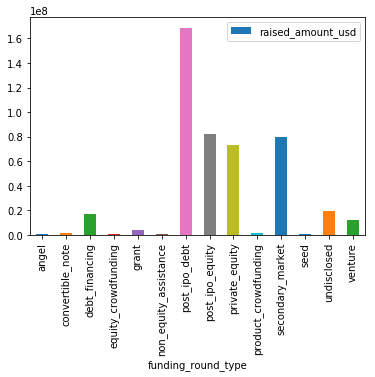

In [15]:
"""Funding Analysis and Spark Fund Requirements"""
print(master_frame)
funding_frame = master_frame[['funding_round_type', 'raised_amount_usd']]
avg_summary_funding_frame = funding_frame.groupby(funding_frame['funding_round_type'], as_index=False).mean()
print(avg_summary_funding_frame)
avg_summary_funding_frame.plot.bar(x='funding_round_type', y='raised_amount_usd')
plt.savefig(r'C:\Users\npatel\Desktop\Upgrad\output.jpeg')
print(avg_summary_funding_frame[(5000000<=avg_summary_funding_frame.raised_amount_usd) & (avg_summary_funding_frame.raised_amount_usd<=15000000)])


              raised_amount_usd
country_code                   
USA                4.225108e+11
CHN                3.983542e+10
GBR                2.024563e+10
IND                1.439186e+10
CAN                9.583332e+09
FRA                7.259537e+09
ISR                6.907515e+09
DEU                6.346960e+09
JPN                3.363677e+09


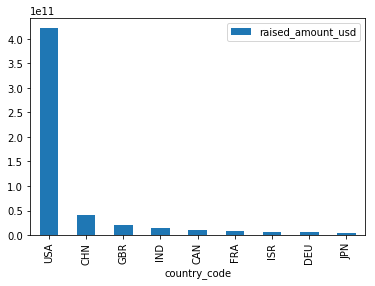

In [16]:
"""Top 9 countries for FT: Venture"""
venture_frame = master_frame[(master_frame.funding_round_type == 'venture')]
top9 = venture_frame.groupby(venture_frame['country_code']).sum().nlargest(9,'raised_amount_usd')
print(top9)
plt.figure()
top9.plot(kind='bar')
plt.show()

In [18]:
"""Sector Mapping and Primary category listing"""
master_frame['category_list'] = master_frame['category_list'].str.split('|')
master_frame['primary_sector'] = master_frame.category_list.str[0]
mapping = pd.read_csv(r'C:\Users\npatel\Desktop\Upgrad\mapping.csv', encoding='ISO-8859-1')
sector_list = mapping.columns.tolist()[1:]
sector_list.remove('Blanks')
for sector in sector_list:
    mapping[sector] = mapping[sector].apply(lambda z: sector if z==1 else '')
mapping['main_sector'] =  mapping[sector_list[0]]
for sector in sector_list[1:]:
    mapping['main_sector'] = mapping['main_sector'] + mapping[sector]
mapping = mapping.drop(columns=sector_list+['Blanks'])
master_sector_frame = pd.merge(master_frame, mapping, how='left', left_on='primary_sector', right_on='category_list')

In [19]:
"""Sector Analysis 1 and 2, FT: Venture, Top 3 sectors country wise"""
master_sector_frame = master_sector_frame.dropna()

# Country: USA, FT: venture
D1 = master_sector_frame[(master_sector_frame['country_code'] == 'USA') & (master_sector_frame['funding_round_type'] == 'venture')]
D1_sector_investments = D1.groupby('main_sector').agg({'funding_round_type':'count',
                                                      'raised_amount_usd': 'sum'}).reset_index().rename(columns={'funding_round_type':'investment_count',
                                                                                                                 'raised_amount_usd': 'total_investments'})
D1 = pd.merge(D1, D1_sector_investments, how='left', left_on='main_sector', right_on='main_sector')
print(D1_sector_investments['investment_count'].sum())
print(D1_sector_investments['total_investments'].sum())
print(D1_sector_investments.nlargest(8,'investment_count'))

D1_sector_investments = D1_sector_investments.nlargest(3,'investment_count')
D1_sector_investments['country'] = D1_sector_investments.investment_count.apply(lambda x: 'USA')
print(D1[D1.main_sector=='Cleantech / Semiconductors'].nlargest(1,'raised_amount_usd'))

17350
259071435712.0
                               main_sector  investment_count  \
6                                   Others              4153   
1               Cleantech / Semiconductors              3597   
7  Social, Finance, Analytics, Advertising              3282   
5               News, Search and Messaging              2591   
3                                   Health              1316   
4                            Manufacturing              1086   
2                            Entertainment              1063   
0                      Automotive & Sports               262   

   total_investments  
6       5.493546e+10  
1       6.799229e+10  
7       4.382120e+10  
5       3.464923e+10  
3       1.969542e+10  
4       1.521406e+10  
2       1.270610e+10  
0       1.005768e+10  
                    company_permalink  \
6373  /organization/greatpoint-energy   

                              funding_round_permalink funding_round_type  \
6373  /funding-round/10052412d43b778

In [20]:
# Country: GBR, FT: venture
D2 = master_sector_frame[(master_sector_frame['country_code'] == 'GBR') & (master_sector_frame['funding_round_type'] == 'venture')]
D2_sector_investments = D2.groupby('main_sector').agg({'funding_round_type':'count',
                                                      'raised_amount_usd': 'sum'}).reset_index().rename(columns={'funding_round_type':'investment_count',
                                                                                                                 'raised_amount_usd': 'total_investments'})
D2 = pd.merge(D2, D2_sector_investments, how='left', left_on='main_sector', right_on='main_sector')
print(D2_sector_investments['investment_count'].sum())
print(D2_sector_investments['total_investments'].sum())
print(D2_sector_investments.nlargest(8,'investment_count'))
D2_sector_investments = D2_sector_investments.nlargest(3,'investment_count')
D2_sector_investments['country'] = D2_sector_investments.investment_count.apply(lambda x: 'GBR')
print(D2[D2.main_sector=='Cleantech / Semiconductors'].nlargest(1,'raised_amount_usd'))

877
11169410374.0
                               main_sector  investment_count  \
6                                   Others               209   
1               Cleantech / Semiconductors               192   
7  Social, Finance, Analytics, Advertising               183   
5               News, Search and Messaging               119   
2                            Entertainment                68   
3                                   Health                46   
4                            Manufacturing                37   
0                      Automotive & Sports                23   

   total_investments  
6       2.683319e+09  
1       2.873991e+09  
7       2.040799e+09  
5       1.225370e+09  
2       8.236511e+08  
3       6.870956e+08  
4       4.509178e+08  
0       3.842663e+08  
            company_permalink  \
10  /organization/adaptimmune   

                            funding_round_permalink funding_round_type  \
10  /funding-round/663f4223e4f1fabee76abe90dcda2795      

In [21]:
# Country: CAN, FT: venture
D3 = master_sector_frame[(master_sector_frame['country_code'] == 'CAN') & (master_sector_frame['funding_round_type'] == 'venture')]
D3_sector_investments = D3.groupby('main_sector').agg({'funding_round_type':'count',
                                                      'raised_amount_usd': 'sum'}).reset_index().rename(columns={'funding_round_type':'investment_count',
                                                                                                                 'raised_amount_usd': 'total_investments'})
D3 = pd.merge(D3, D3_sector_investments, how='left', left_on='main_sector', right_on='main_sector')
print(D3_sector_investments['investment_count'].sum())
print(D3_sector_investments['total_investments'].sum())
print(D3_sector_investments.nlargest(8,'investment_count'))

D3_sector_investments = D3_sector_investments.nlargest(3,'investment_count')
D3_sector_investments['country'] = D3_sector_investments.investment_count.apply(lambda x: 'CAN')
print(D3[D3.main_sector=='Cleantech / Semiconductors'].nlargest(1,'raised_amount_usd'))


526
5150611022.0
                               main_sector  investment_count  \
6                                   Others               144   
1               Cleantech / Semiconductors               119   
7  Social, Finance, Analytics, Advertising                94   
5               News, Search and Messaging                84   
4                            Manufacturing                37   
2                            Entertainment                23   
3                                   Health                23   
0                      Automotive & Sports                 2   

   total_investments  
6       1.469630e+09  
1       1.384799e+09  
7       9.429520e+08  
5       7.597554e+08  
4       2.559215e+08  
2       1.710825e+08  
3       1.624710e+08  
0       4.000000e+06  
                           company_permalink  \
102  /organization/clementia-pharmaceuticals   

                             funding_round_permalink funding_round_type  \
102  /funding-round/7d5ea17